# ResNet Ablation Study  VGG vs ResNet

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load Cats and Dogs Data

In [3]:
import tensorflow_datasets as tfds
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.


(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split = ('train[:80%]', 'train[80%:]'),
    with_info = True,
    as_supervised = True
)

In [4]:
# Tensor은 shape안통한다고 함
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


# Input Normalization

In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_info.features["label"].num_classes

2

In [9]:
ds_info.features["label"].names

['cat', 'dog']

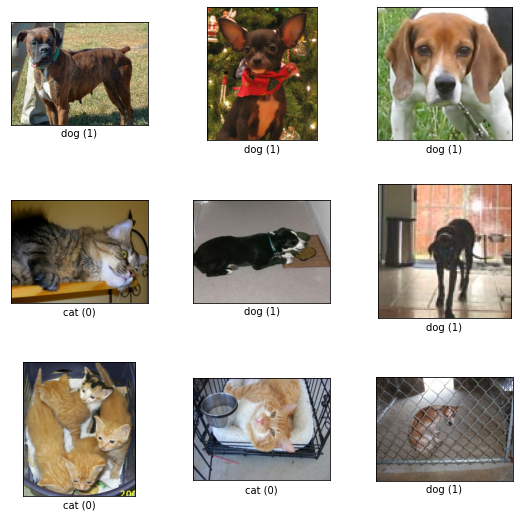

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

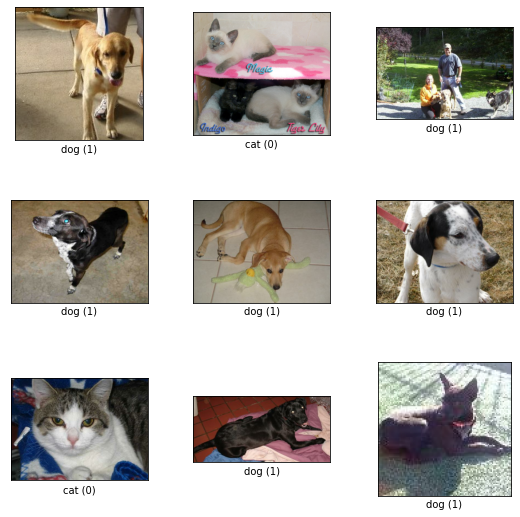

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

* train set과 test set이 8:2 비율로 잘 분리됐다.
* 이미지 resize와 이미지 정규화 작업이 완료됐다.

# Vgg, ResNet 블록 구성하기

## VGG 기본 블록 만들기

![image](https://user-images.githubusercontent.com/68802402/135216055-46f9d43e-1b2d-47b3-bd61-63ad3da6a4c7.png)


In [12]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

* 기본 세팅은  Conv2D 3개(num_cnn=3)와 그 이후 Max Pooling 레이어 가 생성되게끔 되어있다.

In [13]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [14]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


##  VGG Complete Model

### 1) VGG-16

In [15]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=2):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [16]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

### 2) VGG-19


In [17]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

## ResNet 기본 블록 만들기

![image](https://user-images.githubusercontent.com/68802402/135222425-85c0a64f-4ee7-4bc0-bfad-c8b2fa2ab8a6.png)
![image](https://user-images.githubusercontent.com/68802402/135222670-6037ca1d-dc66-4d59-b212-75d1882af1f9.png)


In [66]:
# function for building ResNet Block
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

is_50 = False
is_resnet = True
def build__ResNet_block(input_layer,
                    num_cnn=2, 
                    channel=64,
                    block_num=1,
                    num_repeat = 1,
                    channel_50=256,
                   ):
    # 입력 레이어
    x = input_layer
    shortcut = x

    # CNN 레이어
    for i in range(num_repeat):
        cnt_residual = 0
        cnt_first = 0        
        
        for cnn_num in range(num_cnn):
            if is_50 == True:
                x = keras.layers.Conv2D(filters=channel, kernel_size=(1,1), padding='same')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)
                
                x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), padding='same')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)
                
                x = keras.layers.Conv2D(filters=channel_50, kernel_size=(1,1), padding='same')(x)
                x = BatchNormalization()(x)                
            else:
                x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), padding='same')(x)
                x = BatchNormalization()(x)
                
            cnt_residual += 1
            cnt_first += 1
            if cnt_residual == num_cnn:
                if is_resnet ==True:
                    if is_50 ==True:
                        shortcut = Conv2D(channel_50, (1, 1), strides=(1, 1), padding='valid')(shortcut) 
                        shortcut = BatchNormalization()(shortcut)
                        x = Add()([x, shortcut])
                        x = Activation('relu')(x)
                        shortcut = x
                    else:
                        shortcut = Conv2D(channel, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
                        shortcut = BatchNormalization()(shortcut)
                        x = Add()([x, shortcut])
                        x = Activation('relu')(x)
                        shortcut = x
            else:
                x = Activation('relu')(x)
    
    x = MaxPooling2D((2, 2), 2,padding = "same")(x)   
    
    
    return x

In [67]:
# ResNet모델 자체를 생성하는 함수입니다.
def build_ResNet(input_shape=(32,32,3),
              num_cnn_list=[2,2,2,2],
              channel_list=[64,128,256,512],
              channel_50_list=[256,512,10224,2048],
              num_repeat_list = [3,4,6,3],
              num_classes=2):
    
    assert len(num_repeat_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer

    # ResNet32와 ResNet50의 공통부분(초기 maxpooling) Layer 설정
    output = Conv2D(64, (7, 7), strides=(2, 2,),padding='same')(output)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = MaxPooling2D((3, 3), 2,padding = "same")(output)   
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn,num_repeat, channel,channel_50) in enumerate(zip(num_cnn_list,num_repeat_list, channel_list,channel_50_list)):
        output = build__ResNet_block(
            output,
            num_cnn= num_cnn, 
            num_repeat = num_repeat,
            channel=channel,
            channel_50 = channel_50,
            block_num=i
        )

    output = GlobalAveragePooling2D()(output)
    output = Dense(2, activation='softmax')(output)    # 클래스가 Dog, Cat 2가지이므로 Dense 2
        
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

### 3) ResNet_34

In [68]:
# 기본값을 그대로 사용해서 Resnet 모델을 만들면 Resnet-34가됩니다.
resnet34 = build_ResNet()
resnet34.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_729 (Conv2D)             (None, 16, 16, 64)   9472        input_23[0][0]                   
__________________________________________________________________________________________________
batch_normalization_729 (BatchN (None, 16, 16, 64)   256         conv2d_729[0][0]                 
__________________________________________________________________________________________________
activation_486 (Activation)     (None, 16, 16, 64)   0           batch_normalization_729[0][0]    
___________________________________________________________________________________________

### 5) ResNet_34_Plain


In [69]:
is_resnet = False
resnet34_Plain = build_ResNet()
resnet34_Plain.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_778 (Conv2D)          (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_778 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
activation_519 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_779 (Conv2D)          (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_779 (Bat (None, 8, 8, 64)          256

### 4) ResNet_50

In [72]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
is_50 = True
is_resnet = True
resnet50 = build_ResNet(num_cnn_list=[1,1,1,1])
resnet50.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_925 (Conv2D)             (None, 16, 16, 64)   9472        input_27[0][0]                   
__________________________________________________________________________________________________
batch_normalization_925 (BatchN (None, 16, 16, 64)   256         conv2d_925[0][0]                 
__________________________________________________________________________________________________
activation_618 (Activation)     (None, 16, 16, 64)   0           batch_normalization_925[0][0]    
___________________________________________________________________________________________

### 6) ResNet_50_Plain

In [73]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
is_50 = True
is_resnet = False
resnet50_Plain = build_ResNet(num_cnn_list=[1,1,1,1])
resnet50_Plain.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_990 (Conv2D)          (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_990 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
activation_667 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_991 (Conv2D)          (None, 8, 8, 64)          4160      
_________________________________________________________________
batch_normalization_991 (Bat (None, 8, 8, 64)          256

# ResNet_34, ResNet_50 VGG16, VGG19 훈련

In [78]:
BATCH_SIZE = 256
EPOCH = 40

In [79]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split = ('train[:80%]', 'train[80%:]'),
    with_info = True,
    shuffle_files=True,
    as_supervised = True
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [80]:
# ResNet_34 훈련
resnet34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
72/72 [==============================] - 53s 426ms/step - loss: 0.5682 - accuracy: 0.7104 - val_loss: 0.7276 - val_accuracy: 0.5787
Epoch 2/40
72/72 [==============================] - 30s 413ms/step - loss: 0.5496 - accuracy: 0.7245 - val_loss: 0.6819 - val_accuracy: 0.6158
Epoch 3/40
72/72 [==============================] - 30s 416ms/step - loss: 0.5473 - accuracy: 0.7237 - val_loss: 0.7275 - val_accuracy: 0.6178
Epoch 4/40
72/72 [==============================] - 30s 414ms/step - loss: 0.5175 - accuracy: 0.7422 - val_loss: 0.6968 - val_accuracy: 0.6401
Epoch 5/40
72/72 [==============================] - 29s 412ms/step - loss: 0.4829 - accuracy: 0.7674 - val_loss: 0.7107 - val_accuracy: 0.6296
Epoch 6/40
72/72 [==============================] - 29s 412ms/step - loss: 0.4168 - accuracy: 0.8141 - val_loss: 0.7882 - val_accuracy: 0.6267
Epoch 7/40
72/72 [==============================] - 30s 413ms/step - loss: 0.3826 - accuracy: 0.8299 - val_loss: 0.8251 - val_accuracy: 0.6231

In [81]:
# ResNet_34_Plain 훈련
resnet34_Plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34_Plain = resnet34_Plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
72/72 [==============================] - 47s 385ms/step - loss: 0.8375 - accuracy: 0.5310 - val_loss: 0.6934 - val_accuracy: 0.5191
Epoch 2/40
72/72 [==============================] - 27s 379ms/step - loss: 0.7162 - accuracy: 0.5622 - val_loss: 0.6973 - val_accuracy: 0.5104
Epoch 3/40
72/72 [==============================] - 27s 376ms/step - loss: 0.6604 - accuracy: 0.6256 - val_loss: 0.6998 - val_accuracy: 0.5071
Epoch 4/40
72/72 [==============================] - 27s 380ms/step - loss: 0.6318 - accuracy: 0.6515 - val_loss: 0.6919 - val_accuracy: 0.5122
Epoch 5/40
72/72 [==============================] - 27s 377ms/step - loss: 0.6225 - accuracy: 0.6623 - val_loss: 0.6832 - val_accuracy: 0.5771
Epoch 6/40
72/72 [==============================] - 27s 379ms/step - loss: 0.5740 - accuracy: 0.7031 - val_loss: 0.7506 - val_accuracy: 0.5000
Epoch 7/40
72/72 [==============================] - 27s 378ms/step - loss: 0.5343 - accuracy: 0.7387 - val_loss: 0.6555 - val_accuracy: 0.6153

In [82]:
# ResNet_50 훈련
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
72/72 [==============================] - 365s 4s/step - loss: 0.8896 - accuracy: 0.5062 - val_loss: 0.6928 - val_accuracy: 0.5136
Epoch 2/40
72/72 [==============================] - 322s 4s/step - loss: 0.8178 - accuracy: 0.5012 - val_loss: 0.7034 - val_accuracy: 0.4945
Epoch 3/40
72/72 [==============================] - 281s 4s/step - loss: 0.7807 - accuracy: 0.5080 - val_loss: 0.6940 - val_accuracy: 0.5086
Epoch 4/40
72/72 [==============================] - 284s 4s/step - loss: 0.7761 - accuracy: 0.5056 - val_loss: 0.6973 - val_accuracy: 0.4889
Epoch 5/40
72/72 [==============================] - 282s 4s/step - loss: 0.7649 - accuracy: 0.5158 - val_loss: 0.6996 - val_accuracy: 0.4907
Epoch 6/40
72/72 [==============================] - 282s 4s/step - loss: 0.7554 - accuracy: 0.5079 - val_loss: 0.7019 - val_accuracy: 0.4911
Epoch 7/40
72/72 [==============================] - 282s 4s/step - loss: 0.7431 - accuracy: 0.5151 - val_loss: 0.7024 - val_accuracy: 0.4960
Epoch 8/40
72

In [83]:
# ResNet_50_Plain 훈련
resnet50_Plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50_Plain = resnet50_Plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
72/72 [==============================] - 74s 715ms/step - loss: 0.9135 - accuracy: 0.4953 - val_loss: 0.7008 - val_accuracy: 0.5259
Epoch 2/40
72/72 [==============================] - 50s 704ms/step - loss: 0.7599 - accuracy: 0.5076 - val_loss: 0.7182 - val_accuracy: 0.5061
Epoch 3/40
72/72 [==============================] - 50s 702ms/step - loss: 0.7356 - accuracy: 0.5012 - val_loss: 0.7281 - val_accuracy: 0.5034
Epoch 4/40
72/72 [==============================] - 50s 698ms/step - loss: 0.7277 - accuracy: 0.4962 - val_loss: 0.7193 - val_accuracy: 0.5005
Epoch 5/40
72/72 [==============================] - 51s 705ms/step - loss: 0.7271 - accuracy: 0.4912 - val_loss: 0.7049 - val_accuracy: 0.5054
Epoch 6/40
72/72 [==============================] - 50s 702ms/step - loss: 0.7190 - accuracy: 0.4991 - val_loss: 0.7035 - val_accuracy: 0.5116
Epoch 7/40
72/72 [==============================] - 50s 703ms/step - loss: 0.7197 - accuracy: 0.5007 - val_loss: 0.6972 - val_accuracy: 0.5098

In [84]:
# vgg 16 훈련
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
72/72 [==============================] - 45s 417ms/step - loss: 0.5301 - accuracy: 0.7314 - val_loss: 0.5381 - val_accuracy: 0.7227
Epoch 2/40
72/72 [==============================] - 30s 415ms/step - loss: 0.5085 - accuracy: 0.7433 - val_loss: 0.5579 - val_accuracy: 0.7168
Epoch 3/40
72/72 [==============================] - 30s 417ms/step - loss: 0.5144 - accuracy: 0.7429 - val_loss: 0.5502 - val_accuracy: 0.7207
Epoch 4/40
72/72 [==============================] - 30s 415ms/step - loss: 0.5013 - accuracy: 0.7522 - val_loss: 0.5734 - val_accuracy: 0.7105
Epoch 5/40
72/72 [==============================] - 30s 418ms/step - loss: 0.4835 - accuracy: 0.7672 - val_loss: 0.5350 - val_accuracy: 0.7318
Epoch 6/40
72/72 [==============================] - 30s 415ms/step - loss: 0.4829 - accuracy: 0.7632 - val_loss: 0.5104 - val_accuracy: 0.7556
Epoch 7/40
72/72 [==============================] - 30s 419ms/step - loss: 0.4654 - accuracy: 0.7797 - val_loss: 0.5410 - val_accuracy: 0.7252

In [85]:
# vgg 19 훈련
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
72/72 [==============================] - 49s 463ms/step - loss: 0.5279 - accuracy: 0.7317 - val_loss: 0.5617 - val_accuracy: 0.7120
Epoch 2/40
72/72 [==============================] - 33s 461ms/step - loss: 0.5167 - accuracy: 0.7472 - val_loss: 0.5383 - val_accuracy: 0.7274
Epoch 3/40
72/72 [==============================] - 33s 461ms/step - loss: 0.5147 - accuracy: 0.7459 - val_loss: 0.5242 - val_accuracy: 0.7441
Epoch 4/40
72/72 [==============================] - 33s 461ms/step - loss: 0.5003 - accuracy: 0.7556 - val_loss: 0.5836 - val_accuracy: 0.7024
Epoch 5/40
72/72 [==============================] - 33s 463ms/step - loss: 0.4990 - accuracy: 0.7523 - val_loss: 0.5392 - val_accuracy: 0.7325
Epoch 6/40
72/72 [==============================] - 33s 464ms/step - loss: 0.4731 - accuracy: 0.7733 - val_loss: 0.5555 - val_accuracy: 0.7337
Epoch 7/40
72/72 [==============================] - 33s 464ms/step - loss: 0.4706 - accuracy: 0.7759 - val_loss: 0.5274 - val_accuracy: 0.7382

# Loss, Accuracy Plot

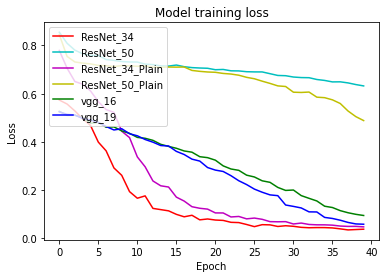

In [86]:
import matplotlib.pyplot as plt
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'c')
plt.plot(history_34_Plain.history['loss'], 'm')
plt.plot(history_50_Plain.history['loss'], 'y')
plt.plot(history_16.history['loss'], 'g')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','ResNet_34_Plain','ResNet_50_Plain','vgg_16', 'vgg_19'], loc='upper left')
plt.show()

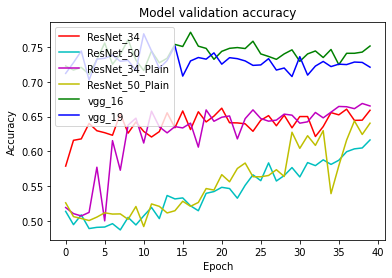

In [87]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'c')
plt.plot(history_34_Plain.history['val_accuracy'], 'm')
plt.plot(history_50_Plain.history['val_accuracy'], 'y')
plt.plot(history_16.history['val_accuracy'], 'g')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','ResNet_34_Plain','ResNet_50_Plain','vgg_16', 'vgg_19'], loc='upper left')
plt.show()

# 평가문항

|평가문항|상세기준|가운데 정렬|
|:---:|:---:|:---:|
|1. ResNet-34, ResNet-50 모델 구현이<br/> 정상적으로 진행되었는가?|블록함수 구현이 제대로 진행되었으며 구현한 <br/>모델의 summary가 예상된 형태로 출력되었다.|ResNet과 Plain의 모델을 적절하게 summarize되게끔 모델을 잘 구현했다. |
|2. 구현한 ResNet 모델을 활용하여 <br/>Image Classification 모델 훈련이 가능한가?|cats_vs_dogs 데이터셋으로 학습시 <br/>몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.|훈련 가능하다. 모두 Accuracy가 증가하고 Loss가 떨어지는 걸 볼 수 있었다. 하지만 ResNet 직접 만든 모델의 파라미터 설정이 인터넷에 나와있는 잘 만들어진 모델의 파라미터와는 달라서 그런지 VGG의 성능을 이기지는 못했다.|
|3. Ablation Study 결과가 <br/>바른 포맷으로 제출되었는가?|ResNet-34, ResNet-50 각각 plain모델과 residual모델을 <br/>동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로<br/> Ablation Study 결과표가 작성되었다.|예상 : ResNet이 VGG 보다 Loss가 낮게, Accuracy는 높게 나와야 함<br/>현실 : ResNet34는 Loss가 낮게 떨어지는 모습을 보였지만 ResNet50은 잘 나오지 않았다. 모델 자체는 summary를 봤을 때 잘 구현됐지만 validation accuracy나 Loss가 만족스럽게 나오지는 못해 아쉬웠다. 파라미터 설정이나 ConV Layer간에 넘어갈 때 MaxPooling의 설정을 바꾸면 더 좋은 결과를 얻을 수도 있을거라고 생각한다.|



